### Q. 로이터 뉴스를 46개의 상호 배타적인 토픽으로 분류하는 신경망 모델 개발
- 데이터 소스 : from keras.datasets import reuters
- 데이터 및 레이블 벡터 변환 : 주어진 사용자 함수 참조
- 모델 구성 : 2개 은닉층(64개 유닛), 1개 출력층
- 검증(validation) : 훈련 데이터에서 1000개 분리하여 검증 데이터로 사용
- 시각화 : 정확도와 손실율 곡선을 비교 시사점 도출

### Reuters newswire topics classification
Dataset of 11,228 newswires from Reuters, labeled over 46 topics. As with the IMDB dataset, each wire is encoded as a sequence of word indexes (same conventions)

https://keras.io/datasets/#reuters-newswire-topics-classification

In [1]:
from keras.datasets import reuters

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, seed=113)

Using TensorFlow backend.


In [2]:
print(len(x_train))

8982


In [3]:
print(len(x_test))

2246


참고: 
https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/3-5-%EB%89%B4%EC%8A%A4-%EA%B8%B0%EC%82%AC-%EB%B6%84%EB%A5%98-%EB%8B%A4%EC%A4%91-%EB%B6%84%EB%A5%98-%EB%AC%B8%EC%A0%9C/

In [4]:
# 데이터를 벡터로 변환
import numpy as np

def vectorize_sequence(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequence(x_train) # 훈련 데이터 벡터 변환
x_test = vectorize_sequence(x_test) # 테스트 데이터 벡터 변환

In [5]:
# 레이블을 벡터로 변환
def to_one_hot(labels, dimension=46):
    result = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        result[i, label] = 1.
    return result

one_hot_train_labels = to_one_hot(y_train) # 훈련 레이블 벡터 변환
one_hot_test_labels = to_one_hot(y_test) # 테스트 레이블 벡터 변환

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_40 (Dense)             (None, 46)                2990      
Total params: 651,374
Trainable params: 651,374
Non-trainable params: 0
_______________________________________________

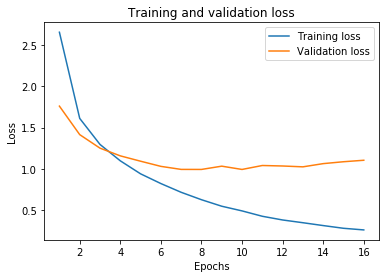

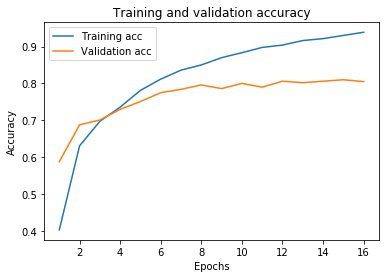

In [15]:
import sklearn.metrics as metrics
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import h5py
import warnings
warnings.filterwarnings('ignore')

# 신경망 모델 정의 16개의 은닉 유닛을 가진 2개의 은닉층(relu) 64개 유닛, 1개의 출력층(softmax)
model = Sequential()
# Input - Layer
model.add(Dense(64, activation='relu', input_shape=(10000, )))
# Hidden - Layers
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(Dense(64, activation = "relu"))
# Output- Layer
model.add(Dense(46, activation = "softmax")) # 다중이므로 softmax 써야 함
model.summary()


# 모델 컴파일하기
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])


# # 학습 실행하기 
# hist = model.fit(x_train, one_hot_train_labels
#                  , batch_size=1000
#                  , epochs=10
#                  , verbose=1
#                  , validation_data=(x_test, one_hot_test_labels))

x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

hist = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=16,
                    batch_size=512,
                    validation_data=(x_val, y_val))

# 모델 성능 평가하기 
score = model.evaluate(x_test, one_hot_test_labels, verbose=1)
print()
print("accuracy=", score[1], 'loss=', score[0])

# 가중치데이터 저장하기 
model.save_weights('./dataset/genre-model.hdf5')

# 에폭별 정확도 시각화
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# 에포크 횟수를 사용해 카운트 객체 생성
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 같은 문제 - 특성행렬 변환으로 tokenizer을 사용한 신경망 모델
- keras에서 tokenizer 제공, 이 방법이 더 쉬움

In [20]:
import numpy as np
from keras.datasets import reuters
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 랜덤 시드를 설정합니다.
np.random.seed(0)

# 필요한 특성 개수를 지정합니다.
number_of_features = 10000

# 특성과 타깃 데이터를 로드합니다.
data = reuters.load_data(num_words=number_of_features)
(data_train, target_vector_train), (data_test, target_vector_test) = data

# 특성 데이터를 원-핫 인코딩된 특성 행렬로 변환합니다.
tokenizer = Tokenizer(num_words=number_of_features)
features_train = tokenizer.sequences_to_matrix(data_train, mode="binary")
features_test = tokenizer.sequences_to_matrix(data_test, mode="binary")

# 참고: 데이터를 벡터로 변환
# import numpy as np

# def vectorize_sequence(sequences, dimension=10000):
#     results = np.zeros((len(sequences), dimension))
#     for i, sequence in enumerate(sequences):
#         results[i, sequence] = 1.
#     return results

# x_train = vectorize_sequence(x_train) # 훈련 데이터 벡터 변환
# x_test = vectorize_sequence(x_test) # 테스트 데이터 벡터 변환


# 타깃 벡터를 원-핫 인코딩하여 타깃 행렬을 만듭니다.
target_train = to_categorical(target_vector_train)
target_test = to_categorical(target_vector_test)

# 참고: 레이블을 벡터로 변환
# def to_one_hot(labels, dimension=46):
#     result = np.zeros((len(labels), dimension))
#     for i, label in enumerate(labels):
#         result[i, label] = 1.
#     return result

# one_hot_train_labels = to_one_hot(y_train) # 훈련 레이블 벡터 변환
# one_hot_test_labels = to_one_hot(y_test) # 테스트 레이블 벡터 변환

# 신경망 모델을 만듭니다.
network = models.Sequential()
network.add(layers.Dropout(0.2, input_shape=(number_of_features,)))

network.add(layers.Dense(units=100,
#                          kernel_regularizer=regularizers.l2(0.01),
                         activation="relu",
                         input_shape=(number_of_features,)))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(units=100,
#                          kernel_regularizer=regularizers.l2(0.01),
                         activation="relu"))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(units=46, activation="softmax"))

# 신경망의 모델 설정을 완료합니다.
# 다중 분류에 맞은 손실 함수인 범주형 크로스엔트로피를 사용하기 위해
# categorical_ crossentropy로 설정
network.compile(loss="categorical_crossentropy", 
                optimizer="rmsprop", # 옵티마이저
                metrics=["accuracy"]) # 성능 지표

# 조기 종료
callbacks = [EarlyStopping(monitor="val_loss", patience=2),
             ModelCheckpoint(filepath="bestm_model.h5",
                             monitor="val_loss",
                             save_best_only=True)]

# 신경망을 훈련합니다.
history = network.fit(features_train, # 특성
                      target_train, # 타깃
                      epochs=30, 
                      verbose=1, # 출력 없음
                      batch_size=100, # 배치의 샘플 개수
                      validation_data=(features_test, target_test)) # 테스트 데이터

# 훈련 손실과 테스트 손실의 기록을 저장합니다.
training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

loss = history.history['loss']
test_loss = history.history['val_loss']

# 에포크 횟수를 사용해 카운트 객체를 만듭니다.
epoch_count = range(1, len(training_accuracy) + 1)

print('\n')
print('모델 성능 :')
score = network.evaluate(features_test, target_test)
print('accuracy= ', score[1], 'loss= ', score[0])

Train on 8982 samples, validate on 2246 samples
Epoch 1/30
8982/8982 [==============================] - 2s 235us/step - loss: 2.0762 - accuracy: 0.5210 - val_loss: 1.4397 - val_accuracy: 0.6812
Epoch 2/30
8982/8982 [==============================] - 2s 218us/step - loss: 1.4040 - accuracy: 0.6776 - val_loss: 1.2643 - val_accuracy: 0.7061
Epoch 3/30
8982/8982 [==============================] - 2s 207us/step - loss: 1.2047 - accuracy: 0.7207 - val_loss: 1.1596 - val_accuracy: 0.7404
Epoch 4/30
8982/8982 [==============================] - 2s 206us/step - loss: 1.0652 - accuracy: 0.7570 - val_loss: 1.1070 - val_accuracy: 0.7609
Epoch 5/30
8982/8982 [==============================] - 2s 207us/step - loss: 0.9813 - accuracy: 0.7784 - val_loss: 1.0672 - val_accuracy: 0.7738
Epoch 6/30
8982/8982 [==============================] - 2s 206us/step - loss: 0.8892 - accuracy: 0.7941 - val_loss: 1.0583 - val_accuracy: 0.7774
Epoch 7/30
8982/8982 [==============================] - 2s 206us/step - loss

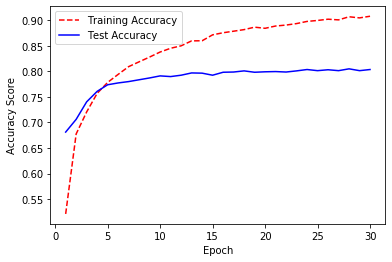

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
# 다른 에디터는 상관 없으나 주피터는 필요
# 시각화
training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, test_accuracy, "b-")

# 정확도 그래프를 그립니다.
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.show()
plt.close()

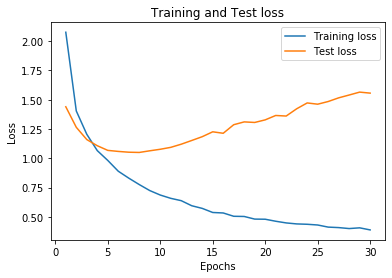

In [24]:
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, test_loss, label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()